# CHAPTER 10 - Quantum Neural Networks - Code

*Note*: You may skip the following seven cells if you have already installed the right versions of all the libraries mentioned in *Appendix D*. This will likely NOT be the case if you are running this notebook on a cloud service such as Google Colab.

**Important - Version Compatibility**: 
PennyLane 0.26 requires specific versions for compatibility:
- **TensorFlow 2.9-2.11** (not 2.12+)
- **Keras 2.x (legacy)** via tf-keras package
- Cell 4 installs the correct TensorFlow version
- Cell 9 installs `tf-keras` (the legacy Keras package)
- Cell 10 sets `TF_USE_LEGACY_KERAS=1` environment variable
- **After installing, restart the kernel and run cells in order**

In [1]:
%pip install scikit-learn>=1.2.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
# PennyLane 0.26 works best with TensorFlow 2.10 (most stable version)
%pip install "tensorflow==2.10.1"

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
   ---------------------------------------- 0.0/455.9 MB ? eta -:--:--
   ---------------------------------------- 3.7/455.9 MB 36.6 MB/s eta 0:00:13
   - -------------------------------------- 14.4/455.9 MB 41.3 MB/s eta 0:00:11
   -- ------------------------------------- 23.1/455.9 MB 41.8 MB/s eta 0:00:11
   -- ------------------------------------- 33.6/455.9 MB 43.5 MB/s eta 0:00:10
   --- ------------------------------------ 43.5/455.9 MB 45.4 MB/s eta 0:00:10
   ---- ----------------------------------- 52.7/455.9 MB 44.2 MB/s eta 0:00:10
   ----- ---------------------------------- 61.9/455.9 MB 44.3 MB/s eta 0:00:09
   ------ --------------------------------- 70.8/455.9 MB 44.3 MB/s eta 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.20.1 requires tensorflow<2.21,>=2.20, but you have tensorflow 2.10.1 which is incompatible.


In [3]:
%pip install pennylane==0.26

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install qiskit==0.39.2

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install qiskit_machine_learning==0.5.0

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install matplotlib>=3.5.0

Note: you may need to restart the kernel to use updated packages.


In [10]:
# Install tf-keras for legacy Keras 2.x support (required for PennyLane 0.26)
%pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------------ --------- 1.3/1.7 MB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 11.5 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Fix for Keras 3.x compatibility with PennyLane 0.26
# This must be set BEFORE importing tensorflow
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
import pennylane as qml
import numpy as np
import tensorflow as tf

seed = 4321
np.random.seed(seed)
tf.random.set_seed(seed)

c:\Users\jebar\miniconda3\envs\myenv1\lib\site-packages\pennylane\__init__.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
tf.keras.backend.set_floatx('float64')

In [4]:
from sklearn.datasets import load_breast_cancer

x,y = load_breast_cancer(return_X_y = True)

In [5]:
from sklearn.model_selection import train_test_split

x_tr, x_test, y_tr, y_test = train_test_split(
    x, y, train_size = 0.8)
x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, train_size = 0.5)

In [6]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_tr)

In [7]:
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

# Restrict all the values to be between 0 and 1.
x_test = np.clip(x_test, 0, 1)
x_val = np.clip(x_val, 0, 1)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)
xs_val = pca.transform(x_val)

In [9]:
from itertools import combinations

def ZZFeatureMap(nqubits, data):

    # Number of variables that we will load:
    # could be smaller than the number of qubits.
    nload = min(len(data), nqubits) 

    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires = i)

    for pair in list(combinations(range(nload), 2)):
        q0 = pair[0]
        q1 = pair[1]

        qml.CZ(wires = [q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) *
            (np.pi - data[q1]), wires = q1)
        qml.CZ(wires = [q0, q1])

def TwoLocal(nqubits, theta, reps = 1):
    
    for r in range(reps):
        for i in range(nqubits):
            qml.RY(theta[r * nqubits + i], wires = i)
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(nqubits):
        qml.RY(theta[reps * nqubits + i], wires = i)

In [10]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [16]:
nqubits = 4
dev = qml.device("default.qubit", wires=nqubits)

def qnn_circuit(inputs, theta):
    ZZFeatureMap(nqubits, inputs)
    TwoLocal(nqubits = nqubits, theta = theta, reps = 1)
    return qml.expval(qml.Hermitian(M, wires = [0]))

# Use numpy interface instead of TensorFlow for compatibility
qnn = qml.QNode(qnn_circuit, dev, interface="autograd")

In [31]:
# Create a custom Keras layer with manual gradient computation in eager mode
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, n_params):
        super().__init__()
        self.n_params = n_params
        # Initialize trainable weights
        self.theta = self.add_weight(
            name='theta',
            shape=(n_params,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float64
        )
    
    def call(self, inputs):
        # Ensure we're in eager mode
        if not tf.executing_eagerly():
            raise RuntimeError("QuantumLayer requires eager execution")
        
        # Get current theta values
        theta_np = self.theta.numpy()
        
        # Convert inputs to numpy if needed
        if isinstance(inputs, tf.Tensor):
            inputs_np = inputs.numpy()
        else:
            inputs_np = inputs
        
        # Forward pass - compute outputs for all samples
        outputs = []
        for sample in inputs_np:
            result = qnn(sample, theta_np)
            outputs.append(result)
        
        outputs = np.array(outputs, dtype=np.float64).reshape(-1, 1)
        
        # Convert to TensorFlow tensor
        return tf.constant(outputs, dtype=tf.float64)
    
    def compute_gradients(self, inputs, upstream_grad):
        """Manually compute gradients using parameter-shift rule."""
        theta_np = self.theta.numpy()
        
        # Convert inputs to numpy if needed
        if isinstance(inputs, tf.Tensor):
            inputs_np = inputs.numpy()
        else:
            inputs_np = inputs
        
        # Convert upstream_grad to numpy if needed
        if isinstance(upstream_grad, tf.Tensor):
            upstream_grad_np = upstream_grad.numpy()
        else:
            upstream_grad_np = upstream_grad
        
        batch_size = len(inputs_np)
        
        # Initialize gradient accumulator
        total_grad = np.zeros_like(theta_np)
        
        # Parameter-shift rule: shift = pi/2
        shift = np.pi / 2
        
        # For each sample in the batch
        for i, sample in enumerate(inputs_np):
            # For each parameter
            for j in range(len(theta_np)):
                theta_plus = theta_np.copy()
                theta_minus = theta_np.copy()
                theta_plus[j] += shift
                theta_minus[j] -= shift
                
                # Compute gradient using parameter-shift
                grad_j = (qnn(sample, theta_plus) - qnn(sample, theta_minus)) / 2.0
                
                # Accumulate gradient weighted by upstream gradient for this sample
                total_grad[j] += upstream_grad_np[i, 0] * grad_j
        
        return tf.constant(total_grad, dtype=tf.float64)

# Create the quantum layer with 8 parameters  
qlayer = QuantumLayer(n_params=8)


In [32]:
# Build the model (we'll use a custom training loop)
model = tf.keras.models.Sequential([qlayer])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)


In [33]:
# Custom training function
def train_step(x_batch, y_batch):
    """Perform one training step with manual gradient computation."""
    # Forward pass
    predictions = qlayer(x_batch)
    
    # Compute loss (binary crossentropy)
    epsilon = 1e-7
    predictions_clipped = tf.clip_by_value(predictions, epsilon, 1 - epsilon)
    loss = -tf.reduce_mean(
        y_batch * tf.math.log(predictions_clipped) + 
        (1 - y_batch) * tf.math.log(1 - predictions_clipped)
    )
    
    # Compute gradients manually (d_loss/d_predictions)
    upstream_grad = (predictions_clipped - y_batch.reshape(-1, 1)) / len(y_batch)
    
    # Get parameter gradients using parameter-shift rule
    param_grads = qlayer.compute_gradients(x_batch, upstream_grad.numpy())
    
    # Apply gradients
    optimizer.apply_gradients([(param_grads, qlayer.theta)])
    
    return loss

def evaluate(x, y):
    """Evaluate the model."""
    predictions = qlayer(x)
    epsilon = 1e-7
    predictions_clipped = tf.clip_by_value(predictions, epsilon, 1 - epsilon)
    loss = -tf.reduce_mean(
        y * tf.math.log(predictions_clipped) + 
        (1 - y) * tf.math.log(1 - predictions_clipped)
    )
    return loss.numpy()

print("Custom training functions defined. Ready to train!")


Custom training functions defined. Ready to train!


In [34]:
# Custom training loop with early stopping
import time

batch_size = 20
epochs = 50
patience = 2

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_theta = None

print("Starting training...")
for epoch in range(epochs):
    epoch_start = time.time()
    
    # Shuffle training data
    indices = np.random.permutation(len(xs_tr))
    xs_tr_shuffled = xs_tr[indices]
    y_tr_shuffled = y_tr[indices]
    
    # Training
    epoch_losses = []
    num_batches = int(np.ceil(len(xs_tr) / batch_size))
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(xs_tr))
        
        x_batch = xs_tr_shuffled[start_idx:end_idx]
        y_batch = y_tr_shuffled[start_idx:end_idx]
        
        loss = train_step(x_batch, y_batch)
        epoch_losses.append(loss.numpy())
    
    # Calculate average training loss
    train_loss = np.mean(epoch_losses)
    train_losses.append(train_loss)
    
    # Validation
    val_loss = evaluate(xs_val, y_val)
    val_losses.append(val_loss)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.1f}s - "
          f"loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_theta = qlayer.theta.numpy().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print("Restoring best weights...")
            qlayer.theta.assign(best_theta)
            break

# Store history in a similar format to Keras
class History:
    def __init__(self):
        self.history = {
            'loss': train_losses,
            'val_loss': val_losses
        }

history = History()
print("\nTraining complete!")


Starting training...
Epoch 1/50 - 108.8s - loss: 0.6767 - val_loss: 0.6732
Epoch 1/50 - 108.8s - loss: 0.6767 - val_loss: 0.6732
Epoch 2/50 - 116.5s - loss: 0.6697 - val_loss: 0.6713
Epoch 2/50 - 116.5s - loss: 0.6697 - val_loss: 0.6713
Epoch 3/50 - 138.7s - loss: 0.6724 - val_loss: 0.6738
Epoch 3/50 - 138.7s - loss: 0.6724 - val_loss: 0.6738
Epoch 4/50 - 142.8s - loss: 0.6769 - val_loss: 0.6780
Early stopping at epoch 4
Restoring best weights...

Training complete!
Epoch 4/50 - 142.8s - loss: 0.6769 - val_loss: 0.6780
Early stopping at epoch 4
Restoring best weights...

Training complete!


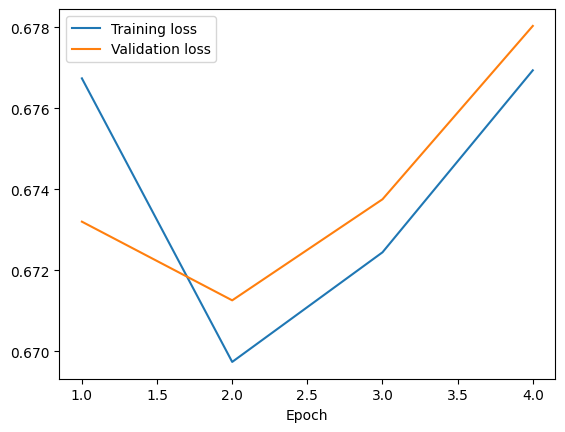

In [35]:
import matplotlib.pyplot as plt

def plot_losses(history):
    tr_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_losses(history)

In [36]:
from sklearn.metrics import accuracy_score

# Get predictions
tr_pred = qlayer(xs_tr).numpy() >= 0.5
val_pred = qlayer(xs_val).numpy() >= 0.5
test_pred = qlayer(xs_test).numpy() >= 0.5

tr_acc = accuracy_score(tr_pred, y_tr)
val_acc = accuracy_score(val_pred, y_val)
test_acc = accuracy_score(test_pred, y_test)

print("Train accuracy:", tr_acc)
print("Validation accuracy:", val_acc)
print("Test accuracy:", test_acc)


Train accuracy: 0.7120879120879121
Validation accuracy: 0.7192982456140351
Test accuracy: 0.7192982456140351


In [37]:
nqubits = 4
dev = qml.device("default.qubit", wires=nqubits)

nreps = 2 
weights_dim = qml.StronglyEntanglingLayers.shape(
    n_layers = nreps, n_wires = nqubits)
nweights = 3 * nreps * nqubits

def qnn_circuit_strong(inputs, theta):
    
    ZZFeatureMap(nqubits, inputs)
    theta1 = tf.reshape(theta, weights_dim)
    qml.StronglyEntanglingLayers(weights = theta1,
                                 wires = range(nqubits))
    
    return qml.expval(qml.Hermitian(M, wires = [0]))

qnn_strong = qml.QNode(qnn_circuit_strong, dev)

weights_strong = {"theta": nweights}

In [38]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

nqubits = 3 # We'll do it for three qubits.

zzfm = ZZFeatureMap(nqubits, reps = 1)
twol = TwoLocal(nqubits, 'ry', 'cx', 'linear', reps = 1)
# Change rep(etition)s above to suit your needs.

In [39]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit.providers.aer import AerSimulator

qnn = TwoLayerQNN(nqubits, feature_map = zzfm, ansatz = twol,
                  quantum_instance = AerSimulator(method="statevector"))

In [40]:
qnn.forward(np.random.rand(qnn.num_inputs),
            np.random.rand(qnn.num_weights))

array([[-0.57939483]])